In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pydotplus 
from IPython.display import Image  
import numpy as np
%matplotlib inline

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
new_df = pd.read_csv('new_child_labor.csv')
new_df.head()

,Unnamed: 0,Child Labor,Country,Forced Labor,Good,celebratory,cigarettes,construction,decorations,energy,...,gems,home_durables,industry,medical,minerals,num_child_produced,num_forced_produced,num_goods,sexual exploitation,technology
0,0,X,Afghanistan,X,Bricks,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,construction,0.0,0.0,4.0,1.0,4.0,0.0,0.0
1,1,X,Angola,X,Diamonds,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,gems,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,2,X,Argentina,NaN,Blueberries,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,food,0.0,0.0,11.0,1.0,11.0,0.0,0.0
3,3,X,Azerbaijan,NaN,Cotton,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,garments,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4,X,Bangladesh,NaN,Bidis (hand-rolled cigarettes),0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,cigarettes,0.0,0.0,15.0,1.0,15.0,0.0,0.0


# Features

* country health expenditure (percent of GDP)
* country education expenditure (percent of GDP)
* country military expendtire (percent of GDP)
* percent of country with access to internet
* primary religion of country
* corruption perception index
* companies per country
* average life expectacy 
* average birth rate
* female population percentage
* happiness index
* GDP (PPP)
* unemployment rate
* family income (Gini index)
* inflation_rate
* value of publicly traded shares in stock market
* exports
* electricity production
* crude oil production
* natural gas production

Goal : build a classifier based off these features that predicts whether or not a country is involved in child labor

In [3]:
# Reading in Files

expenditures = ['health_expenditure.csv', 'education_expenditure.csv', 'military_expenditure.csv']

def extract_file():
    dfs =[]
    for file in expenditures:
        df = pd.read_csv(file, encoding='latin1')
        df.rename(columns={'Name': 'Country', 'Value': 'Percent of GDP'}, inplace=True)
        dfs.append(df)
    return dfs

In [4]:
# Reading in Files

health_expenditures = extract_file()[0]
education_expenditures = extract_file()[1]
military_expenditures = extract_file()[2]

In [5]:
# Reading in Files

internet_data = pd.read_csv('internet_data.csv', encoding='latin1', usecols=['Country or Area', 'Year', 'Value'])
internet_data = internet_data[internet_data['Year']=='2014']

religion_data = pd.read_csv('religions.csv', encoding='latin1', 
                          usecols=['Year' ,'Country', 'Buddhists', 'Christians', 'Muslims', 
                                     'Folk Religions', 'Hindus', 'Jews', 'Other Religions', 'Unaffiliated'])
religion_data = religion_data[religion_data['Year'] == 2020]

corruption = pd.read_csv('corruption.csv', encoding='latin1')
corruption.rename(columns={'Entity': 'Country'}, inplace=True)

companies_per_country = pd.read_csv('companies_per_country.csv', encoding='latin1', usecols=['Country Name', '2016'])
life_expectancy = pd.read_csv('life_expectancy.csv')
birth_rate = pd.read_csv('birth_rate.csv')
female_percentage = pd.read_csv('female_percentage_by_country.csv', encoding='latin1', usecols=['Country Name', '2016'])
happiness = pd.read_csv('world_happiness.csv', encoding='latin1', usecols=['Country', 'Happiness score'])

In [6]:
# Reading in Files

gdp_ppp = pd.read_csv('gdp(ppp).csv')
unemployment_rate = pd.read_csv('unemployment_rate.csv')
family_income = pd.read_csv('familyincome_gini_index.csv')
inflation_rate = pd.read_csv('inflation_rate.csv')
publicly_traded_shares = pd.read_csv('publicly_traded_shares_value.csv')
exports = pd.read_csv('exports.csv')
electricity_production = pd.read_csv('electricity_production.csv')
crude_oil_production = pd.read_csv('crude_oil_production.csv')
natural_gas_production = pd.read_csv('natural_gas_production.csv')

In [7]:
# Latest year for corruption perception index was 2015

corruption = corruption[corruption['Year'] == 2015]

In [8]:
# Clean religion dataframe - column of interest has majority religion for each country

religion_data = religion_data.replace(to_replace='< 1.0', value=0.0)
religion_data = religion_data.replace(to_replace='>99.0', value=100.0)
religion_cols = [col for col in list(religion_data.columns) if col != 'Year' and col !='Country']
religion_data[religion_cols] = religion_data[religion_cols].astype(float)
religion_data['religion'] = religion_data[religion_cols].idxmax(axis=1)
religion_data = religion_data.drop_duplicates('Country')

In [9]:
# compare the sizes of each dataframe

dfs = [health_expenditures, education_expenditures, military_expenditures, internet_data, religion_data, 
      corruption, companies_per_country, life_expectancy, birth_rate, female_percentage, happiness, 
      gdp_ppp, unemployment_rate, family_income, inflation_rate, publicly_traded_shares, exports, 
      electricity_production, crude_oil_production, natural_gas_production]

df_names = ['health_expenditure', 'education_expenditure', 'military_expenditure', 'internet_users', 
            'religion', 'corruption', 'num_companies', 'life_expectancy',
           'birth_rate', 'female_percentage', 'happiness', 'gdp_ppp', 'unemployment_rate', 'family_income', 'inflation_rate',
           'publicly_traded_shares', 'exports', 'electricity_production', 'oil_production', 'natural_gas_production']

df_lengths = {}

for name, df in zip(df_names, dfs):
    df_lengths[name] = len(df)

In [10]:
df_lengths

{'birth_rate': 224,
 'corruption': 168,
 'education_expenditure': 173,
 'electricity_production': 219,
 'exports': 223,
 'family_income': 141,
 'female_percentage': 264,
 'gdp_ppp': 230,
 'happiness': 155,
 'health_expenditure': 191,
 'inflation_rate': 225,
 'internet_users': 202,
 'life_expectancy': 224,
 'military_expenditure': 132,
 'natural_gas_production': 213,
 'num_companies': 264,
 'oil_production': 211,
 'publicly_traded_shares': 120,
 'religion': 235,
 'unemployment_rate': 204}

In [11]:
# create dataframe using Eric's child labor dataframe

child_labor_df = pd.DataFrame(columns=['Country'])
child_labor_df['Country'] = new_df['Country']
child_labor_df.head()

,Country
0,Afghanistan
1,Angola
2,Argentina
3,Azerbaijan
4,Bangladesh


In [12]:
# Preparation for merging the dataframes into child labor dataframe
# If statements renames the target column of interest that will be a feature in child labor dataframe
# cleans the country column name for merge to work

for name, df in zip(df_names, dfs):
    if 'Value' in list(df.columns):
        df.rename(columns={'Value': name}, inplace=True)
    if 'Percent of GDP' in list(df.columns):
        df.rename(columns={'Percent of GDP': name}, inplace=True)
    if '2016' in list(df.columns):
        df.rename(columns={'2016': name}, inplace=True)
    if 'Corruption Perception Index' in list(df.columns):
        df.rename(columns={'Corruption Perception Index': name}, inplace=True)
    if 'Happiness score' in list(df.columns):
        df.rename(columns={'Happiness score': name}, inplace=True)
    if 'Country or Area' in list(df.columns):
        df.rename(columns={'Country or Area': 'Country'}, inplace=True)
    if 'Country Name' in list(df.columns):
        df.rename(columns={'Country Name': 'Country'}, inplace=True)
    if 'Name' in list(df.columns):
        df.rename(columns={'Name': 'Country'}, inplace=True)
    child_labor_df = pd.merge(child_labor_df, df[['Country', name]], how='left', on='Country')

In [13]:
child_labor_df.head()

,Country,health_expenditure,education_expenditure,military_expenditure,internet_users,religion,corruption,num_companies,life_expectancy,birth_rate,...,happiness,gdp_ppp,unemployment_rate,family_income,inflation_rate,publicly_traded_shares,exports,electricity_production,oil_production,natural_gas_production
0,Afghanistan,8.6,NaN,NaN,6.39,Muslims,11.0,NaN,50.87,38.57,...,3.794,$61690000000,35.0,NaN,4.6,NaN,$2785000000,8.331000e+08,1950.0,1.400000e+08
1,Angola,3.5,3.5,3.63,21.26,Christians,15.0,NaN,55.63,38.78,...,3.795,$175500000000,NaN,NaN,7.3,NaN,$69460000000,5.512000e+09,1890000.0,7.600000e+08
2,Argentina,8.5,6.3,0.91,64.7,Christians,32.0,93.0,77.69,16.64,...,6.599,$927400000000,7.7,45.8,36.4,$34240000000,$76470000000,1.232000e+11,691100.0,3.550000e+10
3,Azerbaijan,5.4,2.4,4.70,61,Muslims,29.0,NaN,72.20,16.64,...,5.234,$168400000000,5.4,33.7,1.4,NaN,$30890000000,2.299000e+10,874400.0,1.718000e+10
4,Bangladesh,3.6,2.2,1.15,9.6,Muslims,25.0,557.0,70.94,21.14,...,4.608,$535600000000,5.0,32.1,7.0,$41730000000,$31200000000,4.241000e+10,4200.0,2.186000e+10


In [14]:
len(child_labor_df), len(new_df)

(69, 69)

In [15]:
child_labor_df.describe()

,health_expenditure,education_expenditure,military_expenditure,corruption,num_companies,life_expectancy,birth_rate,female_percentage,happiness,unemployment_rate,family_income,inflation_rate,electricity_production,oil_production,natural_gas_production
count,67.000000,58.000000,51.000000,66.000000,22.000000,66.000000,67.000000,66.000000,66.000000,54.000000,59.000000,67.000000,6.700000e+01,6.700000e+01,6.700000e+01
mean,6.414925,4.432759,1.830588,31.833333,628.545455,66.207121,26.024179,50.305259,4.905258,16.531481,43.638983,6.308955,1.468206e+11,4.980775e+05,2.183963e+10
std,2.505041,2.009834,1.584596,9.330815,1325.332222,8.497436,9.931483,0.902635,1.024058,18.408876,8.335405,6.896568,6.503760e+11,1.424931e+06,8.344769e+10
min,2.000000,1.200000,0.420000,11.000000,8.000000,49.810000,10.720000,48.171971,2.693000,0.000000,28.200000,-1.000000,1.450000e+08,0.000000e+00,0.000000e+00
25%,5.050000,2.900000,0.960000,27.000000,72.250000,59.772500,17.515000,49.886939,4.084750,5.025000,37.650000,2.450000,1.335500e+09,0.000000e+00,0.000000e+00
50%,6.100000,4.300000,1.420000,31.000000,193.000000,68.360000,23.830000,50.184671,4.832000,8.550000,42.500000,5.000000,7.375000e+09,6.750000e+03,0.000000e+00
75%,7.250000,5.575000,2.150000,37.000000,497.750000,73.400000,35.880000,50.777145,5.821250,22.925000,47.400000,7.650000,4.747000e+10,2.393500e+05,1.455500e+10
max,15.500000,13.000000,10.320000,55.000000,5820.000000,78.470000,45.450000,53.775999,7.079000,85.000000,63.200000,36.900000,5.169000e+12,1.005000e+07,6.680000e+11


In [16]:
child_labor_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 21 columns):
Country                   69 non-null object
health_expenditure        67 non-null float64
education_expenditure     58 non-null float64
military_expenditure      51 non-null float64
internet_users            64 non-null object
religion                  68 non-null object
corruption                66 non-null float64
num_companies             22 non-null float64
life_expectancy           66 non-null float64
birth_rate                67 non-null float64
female_percentage         66 non-null float64
happiness                 66 non-null float64
gdp_ppp                   67 non-null object
unemployment_rate         54 non-null float64
family_income             59 non-null float64
inflation_rate            67 non-null float64
publicly_traded_shares    35 non-null object
exports                   66 non-null object
electricity_production    67 non-null float64
oil_production            67 

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


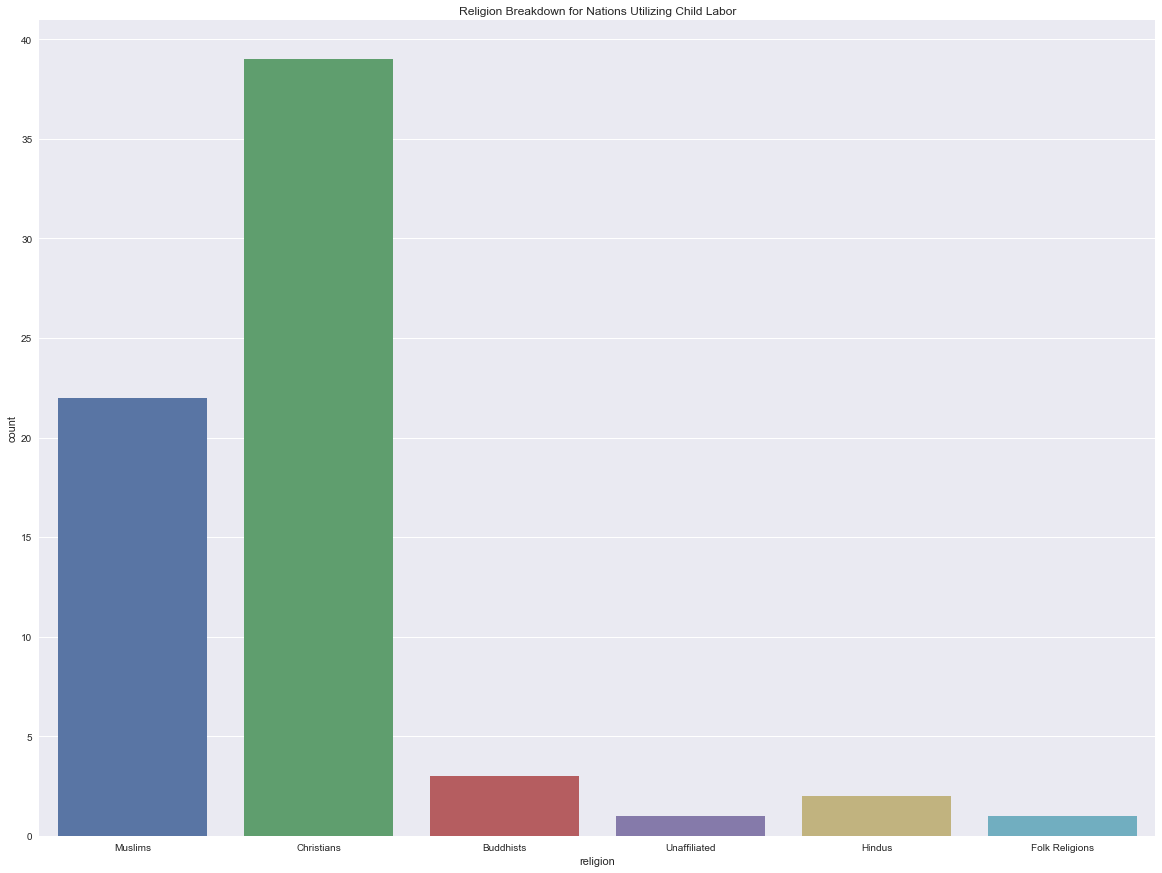

In [17]:
import seaborn as sb
plt.rcParams['figure.figsize'] = (20, 15)

# Out of 69 countries about 40 are majority Christian countries, doesn't tell us much
# Eric's analysis showed India as one of the top utilizers of child labor - heavily Hindu country
# This chart shows implies that Hindu's aren't as involved in child labor, but there are not too many Hindu majority countries
# 

sb.countplot('religion', data=child_labor_df)
plt.title('Religion Breakdown for Nations Utilizing Child Labor')
plt.show()

In [18]:
# Clean up some columns by removing dollar signs
# reduce the production columns

def clean_df(df):    
    df['exports'] = df['exports'].str.replace('$','')
    df['gdp_ppp'] = df['gdp_ppp'].str.replace('$','')
    df['publicly_traded_shares'] = df['publicly_traded_shares'].str.replace('$','')
    df['electricity_production'] = df['electricity_production'] / 1000000
    df['oil_production'] = df['oil_production'] / 1000000
    df['natural_gas_production'] = df['natural_gas_production'] / 1000000
    return df

In [19]:
child_labor_df = clean_df(child_labor_df)

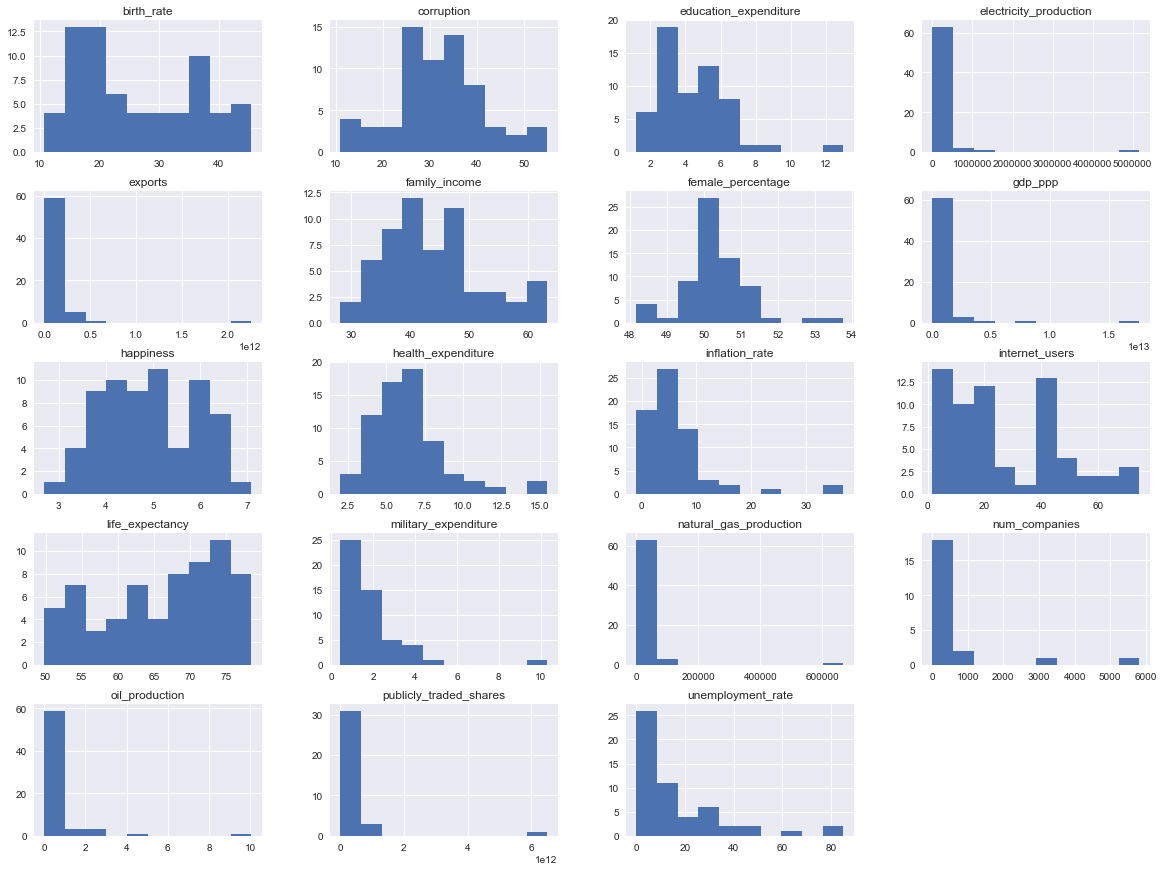

In [20]:
# With only 69 countries in this frame one would expect most feature distributions to be pretty skewed
# Will be interesting to see the effect on the feature distributions in the prediction dataframe when countries not involved in child labor are added

numeric_cols = [col for col in child_labor_df.columns if col != 'religion' and col != 'Country']
child_labor_df[numeric_cols] = child_labor_df[numeric_cols].astype(float)
child_labor_df.hist()
plt.show()

In [21]:
# Create Prediction dataframe

prediction_df = pd.DataFrame(columns=['Country'])
prediction_df['Country'] = companies_per_country['Country']

In [22]:
# Merge with columns of interest as features

for name, df in zip(df_names, dfs):
    prediction_df = pd.merge(prediction_df, df[['Country', name]], how='left', on='Country')

In [23]:
prediction_df.head()

,Country,health_expenditure,education_expenditure,military_expenditure,internet_users,religion,corruption,num_companies,life_expectancy,birth_rate,...,happiness,gdp_ppp,unemployment_rate,family_income,inflation_rate,publicly_traded_shares,exports,electricity_production,oil_production,natural_gas_production
0,Aruba,NaN,6.0,NaN,83.78,Christians,NaN,NaN,76.56,12.56,...,NaN,$2516000000,6.9,NaN,0.5,NaN,$312700000,9.800000e+08,0.0,1.0
1,Afghanistan,8.6,NaN,NaN,6.39,Muslims,11.0,NaN,50.87,38.57,...,3.794,$61690000000,35.0,NaN,4.6,NaN,$2785000000,8.331000e+08,1950.0,140000000.0
2,Angola,3.5,3.5,3.63,21.26,Christians,15.0,NaN,55.63,38.78,...,3.795,$175500000000,NaN,NaN,7.3,NaN,$69460000000,5.512000e+09,1890000.0,760000000.0
3,Albania,6.0,3.3,0.85,60.1,Muslims,36.0,NaN,78.13,12.92,...,4.644,$30660000000,13.3,34.5,1.6,NaN,$2471000000,6.987000e+09,17010.0,10000000.0
4,Andorra,8.3,NaN,NaN,95.9,Christians,NaN,NaN,82.72,8.13,...,NaN,$3163000000,4.0,NaN,1.1,NaN,$70000000,9.124000e+07,NaN,NaN


In [24]:
prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 21 columns):
Country                   264 non-null object
health_expenditure        170 non-null float64
education_expenditure     152 non-null float64
military_expenditure      123 non-null float64
internet_users            177 non-null object
religion                  188 non-null object
corruption                149 non-null float64
num_companies             103 non-null float64
life_expectancy           188 non-null float64
birth_rate                188 non-null float64
female_percentage         240 non-null float64
happiness                 138 non-null float64
gdp_ppp                   191 non-null object
unemployment_rate         168 non-null float64
family_income             128 non-null float64
inflation_rate            190 non-null float64
publicly_traded_shares    106 non-null object
exports                   189 non-null object
electricity_production    185 non-null float64
oil_prod

In [25]:
prediction_df.describe()

,health_expenditure,education_expenditure,military_expenditure,corruption,num_companies,life_expectancy,birth_rate,female_percentage,happiness,unemployment_rate,family_income,inflation_rate,electricity_production,oil_production,natural_gas_production
count,170.000000,152.000000,123.000000,149.000000,103.000000,188.000000,188.000000,240.000000,138.000000,168.000000,128.000000,190.000000,1.850000e+02,1.800000e+02,1.820000e+02
mean,6.980588,4.959211,1.914797,43.651007,3240.601942,71.778617,19.922713,49.930829,5.397341,14.416071,39.597656,3.512632,1.227379e+11,3.907318e+05,1.473955e+10
std,2.829354,2.201575,1.665013,20.168522,6798.020337,8.921812,9.720976,2.934188,1.154572,15.937991,9.709468,4.994288,5.470861e+11,1.377069e+06,5.733605e+10
min,2.000000,0.600000,0.000000,8.000000,6.000000,49.810000,6.650000,24.766120,2.693000,0.000000,23.000000,-2.500000,6.060000e+04,0.000000e+00,0.000000e+00
25%,5.025000,3.375000,0.980000,29.000000,80.000000,66.175000,12.082500,49.568603,4.519250,5.375000,32.250000,0.825000,7.000000e+08,0.000000e+00,0.000000e+00
50%,6.550000,4.800000,1.440000,38.000000,320.000000,74.460000,16.770000,50.189129,5.317500,8.750000,38.850000,2.400000,7.297000e+09,1.000000e+03,0.000000e+00
75%,8.750000,6.000000,2.260000,55.000000,2545.500000,78.392500,24.905000,50.841598,6.353750,16.400000,45.850000,4.975000,4.795000e+10,6.524250e+04,3.084250e+09
max,17.900000,13.000000,10.320000,91.000000,43192.000000,89.520000,45.450000,54.220496,7.537000,95.000000,63.200000,36.900000,5.169000e+12,1.159000e+07,6.876000e+11


In [26]:
# Same cleaning procedure

prediction_df = clean_df(prediction_df)

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


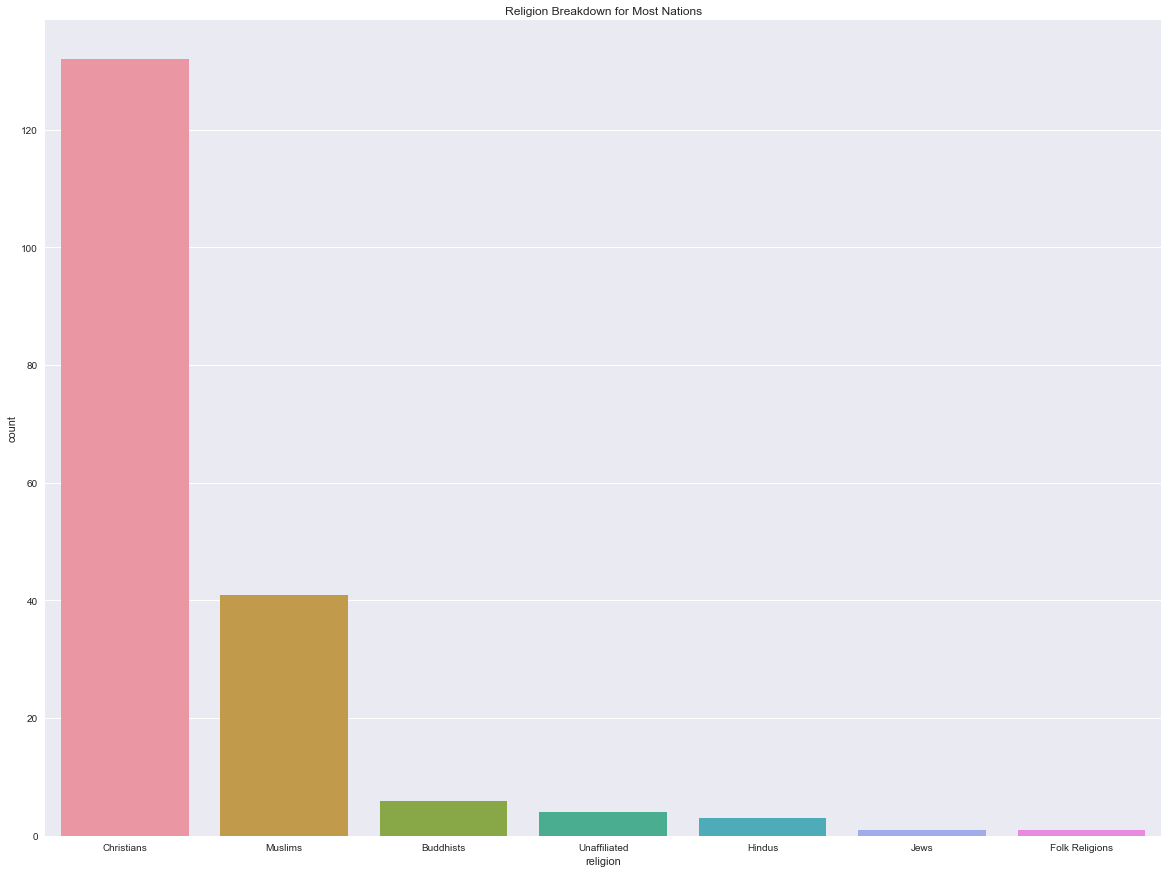

In [27]:
sb.countplot('religion', data=prediction_df)
plt.title('Religion Breakdown for Most Nations')
plt.show()

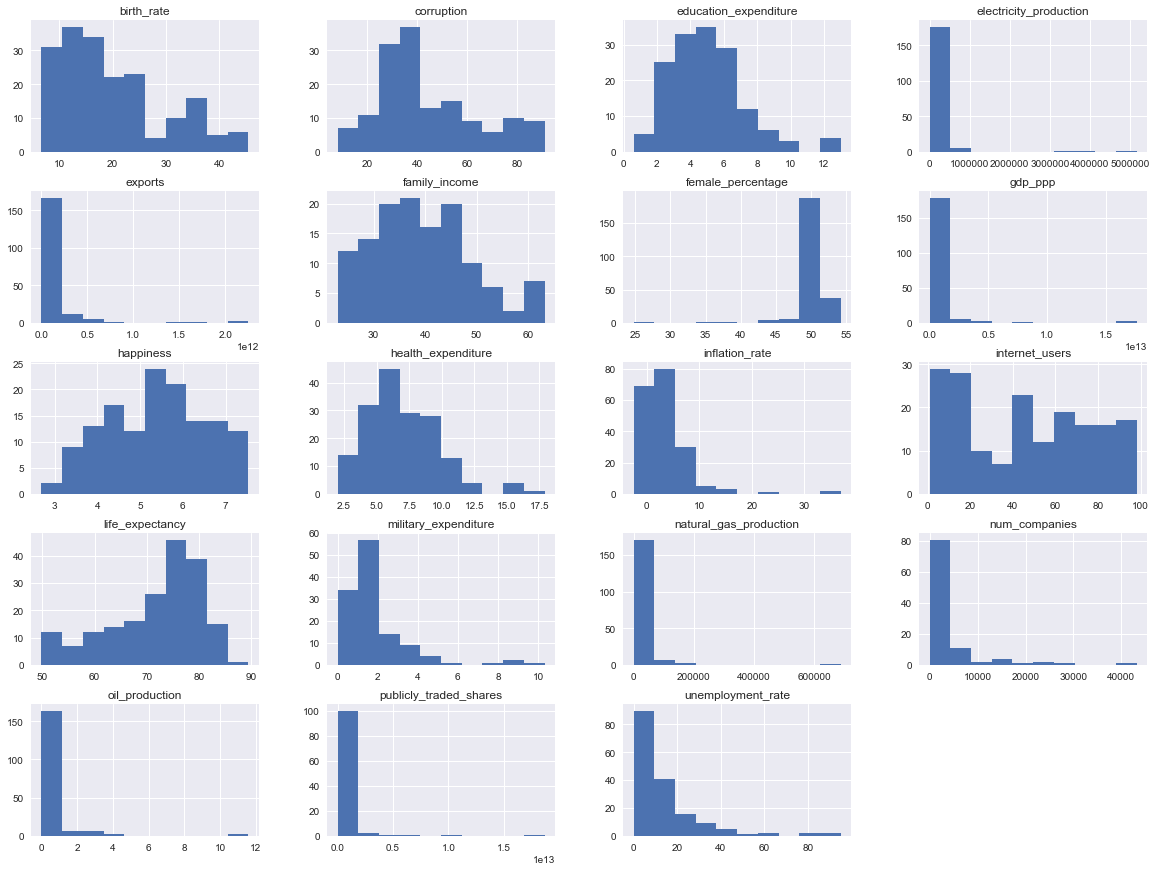

In [28]:
# Feature distributions do not look too much different - 190 ish instances still isn't that much 
# Speaks to the intense wealth gaps prevalent in the world

numeric_cols = [col for col in prediction_df.columns if col != 'religion' and col != 'Country']
prediction_df[numeric_cols] = prediction_df[numeric_cols].astype(float)
prediction_df.hist()
plt.show()

In [29]:
# Replaces NaN's with 0's
# my thoughts were that if the data isn't there for that particular country then that feature probably is a irrelevant for that country

prediction_df = prediction_df.dropna(axis=0, thresh=10)
prediction_df = prediction_df.replace(to_replace=np.nan, value=0.0)
len(prediction_df)

187

In [30]:
prediction_df.head()

,Country,health_expenditure,education_expenditure,military_expenditure,internet_users,religion,corruption,num_companies,life_expectancy,birth_rate,...,happiness,gdp_ppp,unemployment_rate,family_income,inflation_rate,publicly_traded_shares,exports,electricity_production,oil_production,natural_gas_production
0,Aruba,0.0,6.0,0.00,83.78,Christians,0.0,0.0,76.56,12.56,...,0.000,2.516000e+09,6.9,0.0,0.5,0.0,3.127000e+08,980.00,0.00000,0.000001
1,Afghanistan,8.6,0.0,0.00,6.39,Muslims,11.0,0.0,50.87,38.57,...,3.794,6.169000e+10,35.0,0.0,4.6,0.0,2.785000e+09,833.10,0.00195,140.000000
2,Angola,3.5,3.5,3.63,21.26,Christians,15.0,0.0,55.63,38.78,...,3.795,1.755000e+11,0.0,0.0,7.3,0.0,6.946000e+10,5512.00,1.89000,760.000000
3,Albania,6.0,3.3,0.85,60.10,Muslims,36.0,0.0,78.13,12.92,...,4.644,3.066000e+10,13.3,34.5,1.6,0.0,2.471000e+09,6987.00,0.01701,10.000000
4,Andorra,8.3,0.0,0.00,95.90,Christians,0.0,0.0,82.72,8.13,...,0.000,3.163000e+09,4.0,0.0,1.1,0.0,7.000000e+07,91.24,0.00000,0.000000


In [31]:
religions = pd.get_dummies(prediction_df['religion'])
religions["Country"] = prediction_df["Country"]
prediction_df = pd.merge(prediction_df, religions, on='Country')

In [32]:
prediction_df.head()

,Country,health_expenditure,education_expenditure,military_expenditure,internet_users,religion,corruption,num_companies,life_expectancy,birth_rate,...,oil_production,natural_gas_production,0.0,Buddhists,Christians,Folk Religions,Hindus,Jews,Muslims,Unaffiliated
0,Aruba,0.0,6.0,0.00,83.78,Christians,0.0,0.0,76.56,12.56,...,0.00000,0.000001,0,0,1,0,0,0,0,0
1,Afghanistan,8.6,0.0,0.00,6.39,Muslims,11.0,0.0,50.87,38.57,...,0.00195,140.000000,0,0,0,0,0,0,1,0
2,Angola,3.5,3.5,3.63,21.26,Christians,15.0,0.0,55.63,38.78,...,1.89000,760.000000,0,0,1,0,0,0,0,0
3,Albania,6.0,3.3,0.85,60.10,Muslims,36.0,0.0,78.13,12.92,...,0.01701,10.000000,0,0,0,0,0,0,1,0
4,Andorra,8.3,0.0,0.00,95.90,Christians,0.0,0.0,82.72,8.13,...,0.00000,0.000000,0,0,1,0,0,0,0,0


In [33]:
# About a 2/3 to 1/3 target class split

prediction_df.drop(['religion', 0.0], axis=1, inplace=True)
prediction_df['Child Labor'] = prediction_df['Country'].isin(new_df['Country'])
prediction_df['Child Labor'].value_counts()

False    122
True      65
Name: Child Labor, dtype: int64

In [34]:
prediction_df.drop('Country', axis=1, inplace=True)
prediction_df.head()

,health_expenditure,education_expenditure,military_expenditure,internet_users,corruption,num_companies,life_expectancy,birth_rate,female_percentage,happiness,...,oil_production,natural_gas_production,Buddhists,Christians,Folk Religions,Hindus,Jews,Muslims,Unaffiliated,Child Labor
0,0.0,6.0,0.00,83.78,0.0,0.0,76.56,12.56,52.491485,0.000,...,0.00000,0.000001,0,1,0,0,0,0,0,False
1,8.6,0.0,0.00,6.39,11.0,0.0,50.87,38.57,48.452199,3.794,...,0.00195,140.000000,0,0,0,0,0,1,0,True
2,3.5,3.5,3.63,21.26,15.0,0.0,55.63,38.78,50.976371,3.795,...,1.89000,760.000000,0,1,0,0,0,0,0,True
3,6.0,3.3,0.85,60.10,36.0,0.0,78.13,12.92,49.504843,4.644,...,0.01701,10.000000,0,0,0,0,0,1,0,False
4,8.3,0.0,0.00,95.90,0.0,0.0,82.72,8.13,0.000000,0.000,...,0.00000,0.000000,0,1,0,0,0,0,0,False


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [36]:
array = prediction_df.values

X = array[:,0:26].astype(float)
y = array[:,26].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [37]:
num_folds=10
seed=7
scoring='accuracy'

# Standardize the dataset
# Compare Logistic Regression, KNN, Decision Tree, SVM
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledKN', Pipeline([('Scaler', StandardScaler()), ('KN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

scaled_results = []
scaled_names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    scaled_results.append(cv_results)
    scaled_names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

ScaledLR: 0.818095 (0.081422)
ScaledKN: 0.759048 (0.066537)
ScaledCART: 0.791905 (0.113330)
ScaledSVM: 0.811905 (0.050451)


In [38]:
from sklearn.model_selection import GridSearchCV

# Tune Logistic Regression

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

param_grid = {'penalty': ['l1', 'l2'], 'C': [1.0, 10.0, 100.0]}
model=LogisticRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, std, param))

Best: 0.859060 using {'C': 1.0, 'penalty': 'l1'}
0.859060 (0.069112) with: {'C': 1.0, 'penalty': 'l1'}
0.832215 (0.076919) with: {'C': 1.0, 'penalty': 'l2'}
0.805369 (0.099487) with: {'C': 10.0, 'penalty': 'l1'}
0.825503 (0.103045) with: {'C': 10.0, 'penalty': 'l2'}
0.805369 (0.093355) with: {'C': 100.0, 'penalty': 'l1'}
0.805369 (0.103887) with: {'C': 100.0, 'penalty': 'l2'}


In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# prepare model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = LogisticRegression(penalty= 'l1', C=1.0)
model.fit(rescaledX, y_train)

# estimate accuracy on test set

rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.815789473684
[[18  3]
 [ 4 13]]
             precision    recall  f1-score   support

          0       0.82      0.86      0.84        21
          1       0.81      0.76      0.79        17

avg / total       0.82      0.82      0.82        38



In [40]:
# Corruption, birth_rate, happiness, family income, inflation rate, exports have decent impacts on the log odds

features = [col for col in prediction_df.columns if col != 'Child Labor']
coefficients = model.coef_.tolist()[0]
for feature, coef in zip(features, coefficients):
    print('{0}: {1}'.format(feature, coef))

health_expenditure: 0.0
education_expenditure: 0.0
military_expenditure: -0.1324737819360596
internet_users: -0.20408997410578614
corruption: -1.4694263833495402
num_companies: 0.0
life_expectancy: -0.14049970060171546
birth_rate: 1.1293456914789286
female_percentage: 0.0
happiness: 1.9050882176422101
gdp_ppp: 0.0
unemployment_rate: -0.08061215449585456
family_income: 0.9832225907607037
inflation_rate: 0.5514487676383217
publicly_traded_shares: -0.17043573028473924
exports: 0.28087030149268105
electricity_production: 0.037725885680965916
oil_production: 0.05900398814494029
natural_gas_production: 0.0
Buddhists: 0.03144579936723234
Christians: 0.0
Folk Religions: 0.0
Hindus: 0.006786865925713386
Jews: -0.0937705576152776
Muslims: 0.012591401978016186
Unaffiliated: 0.0


In [41]:
from sklearn import tree

lr_tree = tree.DecisionTreeClassifier()
output = model.predict(rescaledX)
lr_tree_model = lr_tree.fit(rescaledX, output)

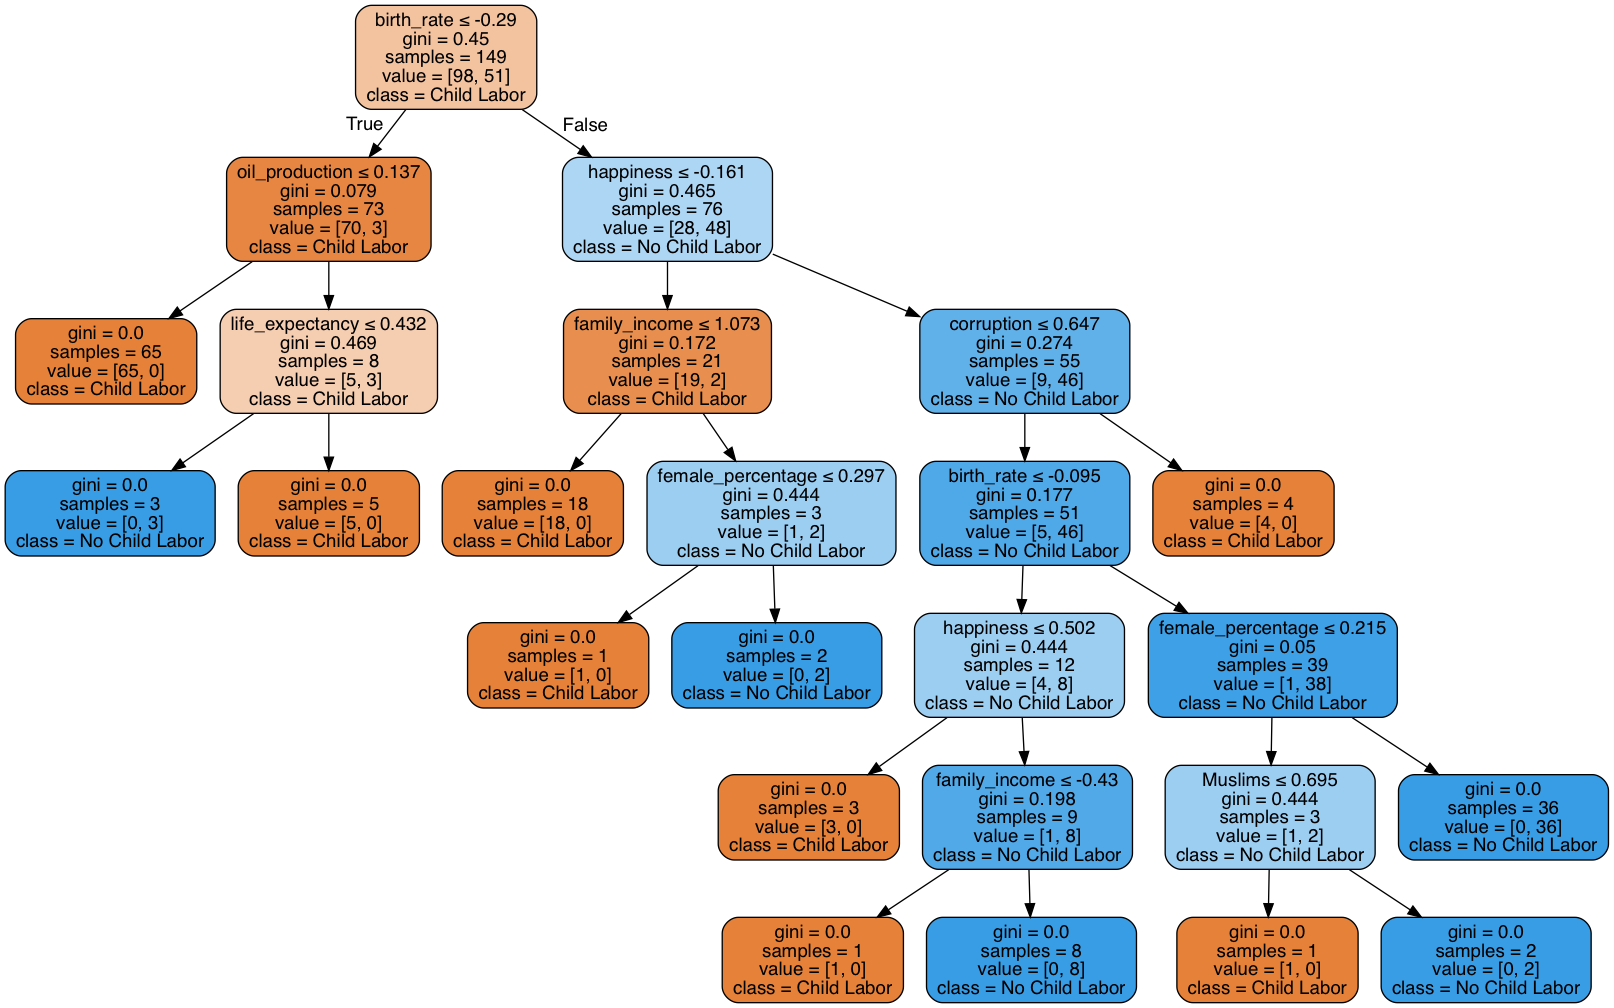

In [42]:
dot_data = tree.export_graphviz(lr_tree_model, out_file=None, 
                         feature_names=features,  
                         class_names=['Child Labor', 'No Child Labor'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
picture = Image(graph.create_png())

picture

In [43]:
ensembles = []
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))

ensemble_results = []
ensemble_names = []

for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    ensemble_results.append(cv_results)
    ensemble_names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

GBM: 0.825238 (0.124030)
RF: 0.832381 (0.085311)


In [44]:
# prepare model

scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingClassifier()
model.fit(rescaledX, y_train)

# estimate accuracy on test set

rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.763157894737
[[19  2]
 [ 7 10]]
             precision    recall  f1-score   support

          0       0.73      0.90      0.81        21
          1       0.83      0.59      0.69        17

avg / total       0.78      0.76      0.76        38



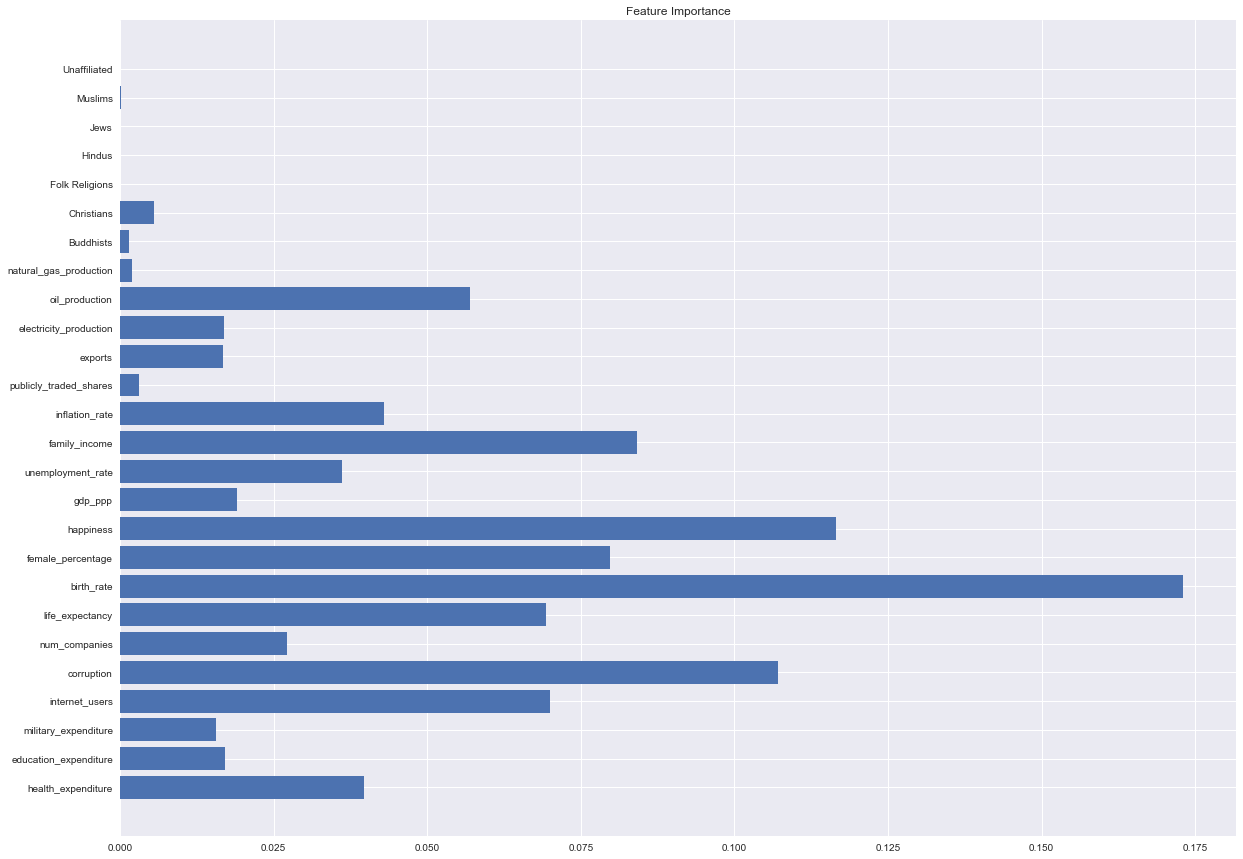

In [45]:
y_pos = np.arange(len(features))

plt.barh(y_pos, model.feature_importances_, align='center')
plt.yticks(y_pos, features)
plt.title('Feature Importance')

plt.show()

In [46]:
# Create model with top 10 features from boosted model

feature_importances = dict(zip(features, model.feature_importances_))
top_10_features = sorted(feature_importances, key=feature_importances.get, reverse=True)[:10]
top_10_feature_df = prediction_df.ix[:,prediction_df.columns.isin(top_10_features)]
top_10_feature_df['Child Labor'] = prediction_df['Child Labor']

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
top_10_feature_df.head()

,health_expenditure,internet_users,corruption,life_expectancy,birth_rate,female_percentage,happiness,family_income,inflation_rate,oil_production,Child Labor
0,0.0,83.78,0.0,76.56,12.56,52.491485,0.000,0.0,0.5,0.00000,False
1,8.6,6.39,11.0,50.87,38.57,48.452199,3.794,0.0,4.6,0.00195,True
2,3.5,21.26,15.0,55.63,38.78,50.976371,3.795,0.0,7.3,1.89000,True
3,6.0,60.10,36.0,78.13,12.92,49.504843,4.644,34.5,1.6,0.01701,False
4,8.3,95.90,0.0,82.72,8.13,0.000000,0.000,0.0,1.1,0.00000,False


In [48]:
array = top_10_feature_df.values

X = array[:,0:10].astype(float)
y = array[:,10].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [49]:
# SVM training error gets far worse, LR gets even better

models=[]
models.append(('LR', LogisticRegression()))
models.append(('KN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.866190 (0.059111)
KN: 0.818571 (0.099487)
CART: 0.845238 (0.074360)
SVM: 0.676190 (0.129187)


In [50]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

param_grid = {'penalty': ['l1', 'l2'], 'C': [1.0, 10.0, 100.0]}
model=LogisticRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, std, param))

Best: 0.885906 using {'C': 1.0, 'penalty': 'l2'}
0.879195 (0.049399) with: {'C': 1.0, 'penalty': 'l1'}
0.885906 (0.042186) with: {'C': 1.0, 'penalty': 'l2'}
0.885906 (0.051715) with: {'C': 10.0, 'penalty': 'l1'}
0.885906 (0.051715) with: {'C': 10.0, 'penalty': 'l2'}
0.885906 (0.051715) with: {'C': 100.0, 'penalty': 'l1'}
0.885906 (0.051715) with: {'C': 100.0, 'penalty': 'l2'}


In [51]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = LogisticRegression(penalty= 'l2', C=1.0)
model.fit(rescaledX, y_train)

# test performance slightly declines - overfitting with less features is a bit strange

rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.789473684211
[[16  5]
 [ 3 14]]
             precision    recall  f1-score   support

          0       0.84      0.76      0.80        21
          1       0.74      0.82      0.78        17

avg / total       0.80      0.79      0.79        38



In [52]:
coefficients = model.coef_.tolist()[0]
for feature, coef in zip(top_10_features, coefficients):
    print('{0}: {1}'.format(feature, coef))

birth_rate: -0.05551721426551912
happiness: -0.43216959033861124
corruption: -1.2573363831502335
family_income: -0.17927034977664458
female_percentage: 0.8955230356484785
internet_users: 0.24654939920913185
life_expectancy: 1.668799252852588
oil_production: 0.8892109194230032
inflation_rate: 0.6136955141775416
health_expenditure: 0.18003951434669244


In [53]:
lr_tree = tree.DecisionTreeClassifier()
output = model.predict(rescaledX)
lr_tree_model = lr_tree.fit(rescaledX, output)

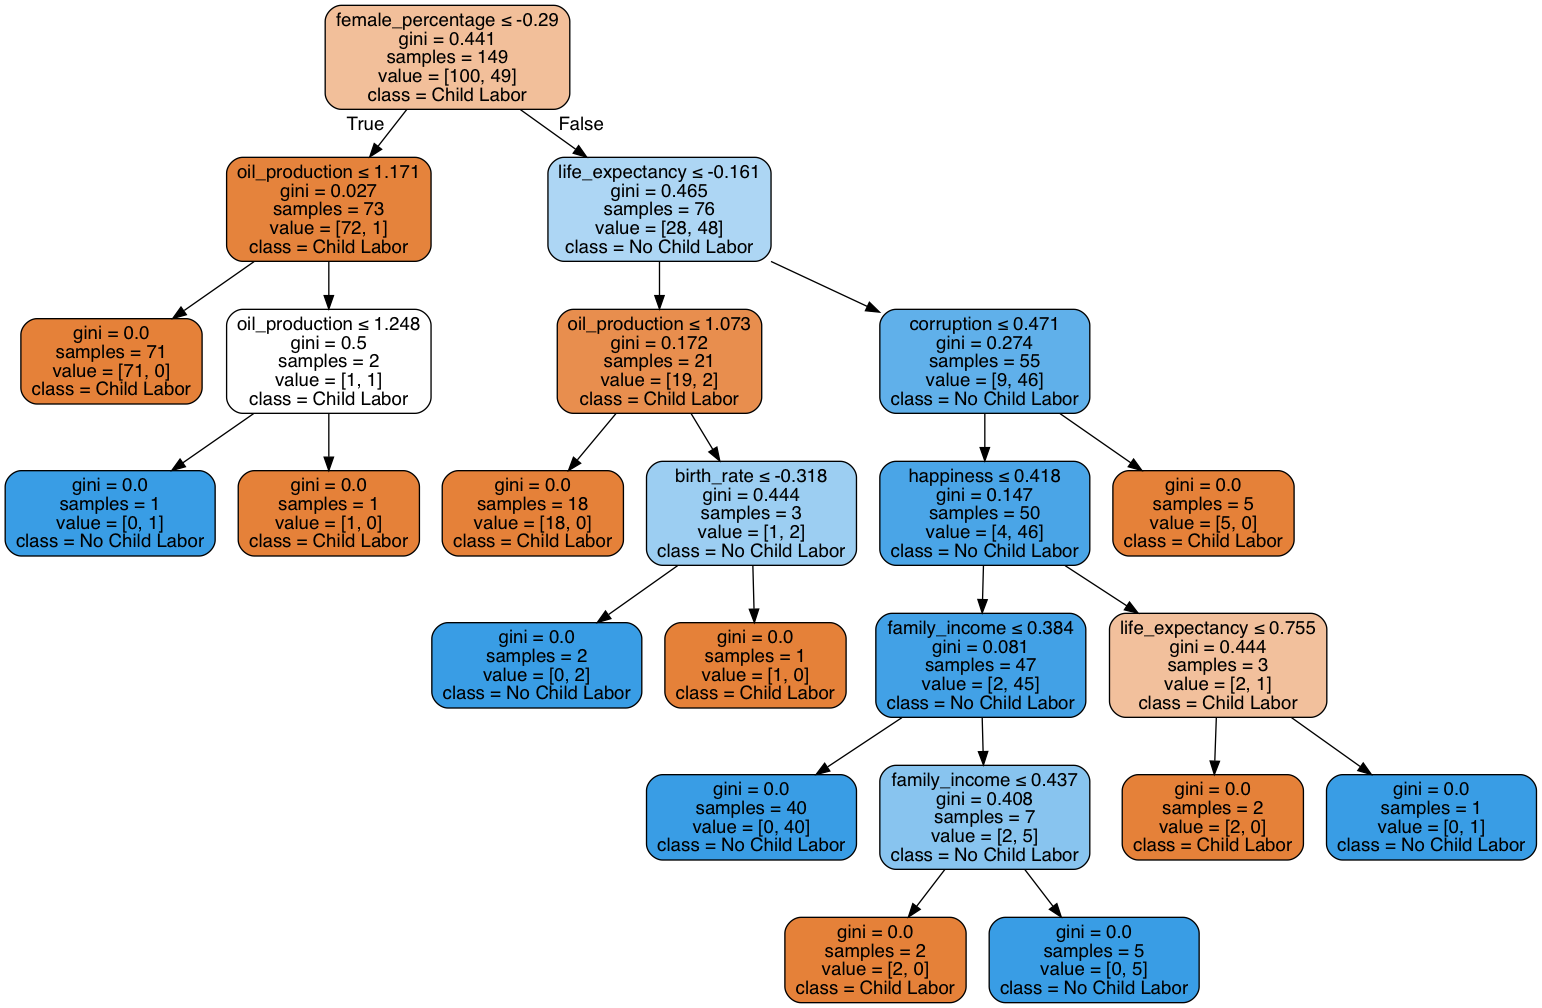

In [54]:
dot_data = tree.export_graphviz(lr_tree_model, out_file=None, 
                         feature_names=top_10_features,  
                         class_names=['Child Labor', 'No Child Labor'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
picture = Image(graph.create_png())

picture

# Next Steps

* Spend more time looking for feature ideas from Eric's first notebook
* mostly interested in the technological, political, and education impacts